In [1]:
import numpy as np
import matplotlib
import matplotlib.image as image
import matplotlib.pyplot as plt
from skimage.transform import AffineTransform, ProjectiveTransform, warp
%matplotlib notebook
                     # NOTE: all "magic" options for backend plotting are: inline, notebook, and "external" (default) 
                     # see  http://ipython.readthedocs.io/en/stable/interactive/plotting.html for details

### LineBuilder class for entering correspoinding points in each image
###### Note: left mouse clicks add polyline intervals, the right mouse click terminates the polyline, 'DEL' key removes the last click point

In [2]:
class LineBuilder:

    def __init__(self, axes, line):
        self.line = line
        self.ax = axes
        self.xs = list(line.get_xdata())
        self.ys = list(line.get_ydata())
        self.dashed_line = plt.Line2D((0,0),(0,0), color = line.get_c(), ls=':', lw=line.get_linewidth())
        self.terminated = False
        
        self.connect()
        
    def connect(self):
        # 'connect to all the events we need'
        self.cidpress = self.ax.figure.canvas.mpl_connect('button_press_event', self.on_click)
        self.cidmotion = self.ax.figure.canvas.mpl_connect('motion_notify_event', self.on_motion)
        self.cidkey = self.ax.figure.canvas.mpl_connect('key_press_event', self.on_key_down)

        
    def on_click(self, event):
        if ((self.terminated==True) or (event.inaxes!=self.line.axes)): return
        self.xs.append(event.xdata)
        self.ys.append(event.ydata)
        self.line.set_data(self.xs, self.ys)
        #self.ax.add_patch(plt.Circle((event.xdata,event.ydata), radius=5, fc='y'))
        self.line.figure.canvas.draw()
        if (event.button==3): self.terminated = True   #right mouse click terminates the polyline 
            
    def on_motion(self, event):
        if ((self.terminated==True) or (event.inaxes!=self.line.axes) or (len(self.xs)==0)): return
        self.dashed_line.set_xdata([self.xs[-1],event.xdata])
        self.dashed_line.set_ydata([self.ys[-1],event.ydata])
        self.ax.add_line(self.dashed_line)
        
    def on_key_down(self, e): # do the following when certain "key" is pressed
        if (e.inaxes!=self.ax.axes): return
        if e.key == 'delete' :  # pressing 'DELETE' key deletes the last click
            if self.xs : self.xs.pop()
            if self.ys : self.ys.pop()
            self.line.set_data(self.xs, self.ys)
            self.dashed_line.set_xdata([])
            self.dashed_line.set_ydata([])
            self.line.figure.canvas.draw()
            self.terminated = False
    
    def disconnect(self):
        # 'disconnect all the stored connection ids'
        self.ax.figure.canvas.mpl_disconnect(self.cidmotion)   
        self.ax.figure.canvas.mpl_disconnect(self.cidpress)
        self.ax.figure.canvas.mpl_disconnect(self.cidkey)

### CrossDissolver class
###### Note: click on the left side to move back to image A, clicks on the right side to move forward to image B

In [3]:
# ASSUMPTION: images A and B should have the same size and the same data type ('uint8' {0,1,2,...,255} or 'float' [0,1])
class CrossDissolver:

    def __init__(self, axes, imA, imB, dtype = 'uint8'):
        self.ax = axes
        scaler = 1.0/255.0
        if (dtype == 'float') : scaler = 1.0
        self.A = scaler * np.array(imA)    # generating array A with (RGB) float values in the range [0,1]
        self.B = scaler * np.array(imB)    # generating array B with (RGB) float values in the range [0,1]
        self.t = 0.5
        self.width = imA.shape[1]
        self.text_pos = (self.width+20, 20)                 
        self.cidpress = self.ax.figure.canvas.mpl_connect('button_press_event', self.on_click)
        self.showMix()       
                            
    def on_click(self, event):
        if (event.inaxes!=self.ax.axes): return
        if (event.xdata>(self.width/2)):  self.t = min(1.0,self.t+0.1)
        if (event.xdata<(self.width/2)):  self.t = max(0.0,self.t-0.1)           
        self.showMix()
         
    def showMix(self):
        self.ax.imshow((1.0-self.t)*self.A + self.t*self.B)
        self.ax.text(self.text_pos[0], self.text_pos[1], 't = {:4.2f}'.format(self.t), color='y', backgroundcolor='gray') 

# Homographies

<IPython.core.display.Javascript object>


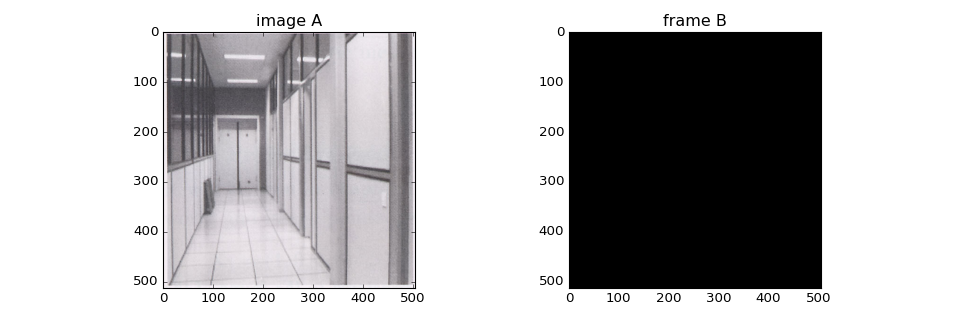

In [4]:
imA = image.imread("images/hall.png")
imB = np.zeros((imA.shape[0],imA.shape[1]), dtype=np.int8)

fig = plt.figure(1,figsize = (12, 4))
axA = plt.subplot(121)
polylineA = LineBuilder(axA, plt.plot([], [], 'ro-')[0] )  # instantiates LineBuilder object
axA.imshow(imA)
plt.title("image A")

axB = plt.subplot(122)
polylineB = LineBuilder(axB, plt.plot([], [], 'bo-')[0] )  # instantiates LineBuilder object
axB.imshow(imB, cmap = "gray")
plt.title("frame B")

# (Left) click on two images below to consecutively enter corresponding points (right clicks enter the last points)
# Press "DEL" key to delete the last click point.
# You should enter at least 4 points (to define a proper homography)

### Warping image A onto frame B using a homographic transofmation (projective map)
###### NOTE: function "warp" uses "inverse map" as a (second) argument as it uses "inverse warping" to compute output intensities

In [5]:
ptsA = polylineA.line.get_xydata()   # extracts a sequnce of 2D points (x,y) from the polyline
ptsB = polylineB.line.get_xydata()

ProjAtoB = ProjectiveTransform()    
ProjAtoB.estimate(ptsA, ptsB)      # computes projective map from points ptsA to points ptsB
imB = warp(imA, ProjAtoB.inverse)

axB.imshow(imB)
axB.set_title("Projecting A onto frame B")

C:\Users\JLee\Anaconda2\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\Users\JLee\Anaconda2\lib\site-packages\numpy\core\_methods.py:68: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\JLee\Anaconda2\lib\site-packages\skimage\transform\_geometric.py:53: RuntimeWarning: invalid value encountered in double_scalars
  rms = math.sqrt(np.sum((points - centroid) ** 2) / points.shape[0])


LinAlgError: Arrays cannot be empty

# Panoramas (projective and other transformations)

<IPython.core.display.Javascript object>


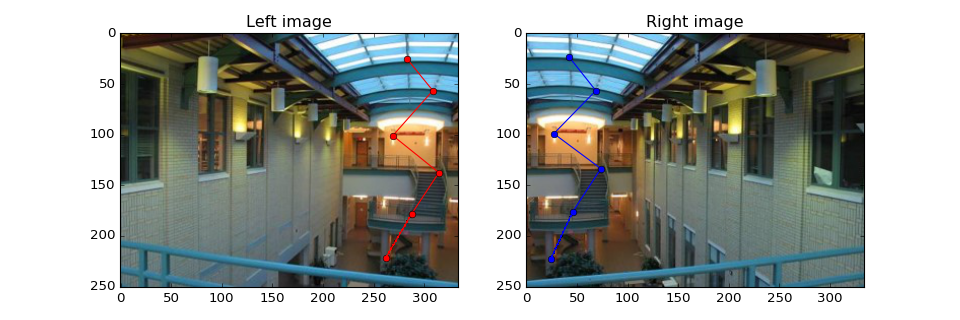

In [10]:
imL = image.imread("images/CMU_left.jpg")
imR = image.imread("images/CMU_right.jpg")

fig = plt.figure(2,figsize = (12, 4))
axL = plt.subplot(121)
polylineL = LineBuilder(axL, plt.plot([], [], 'ro-')[0] )  # instantiates LineBuilder object
axL.imshow(imL)
axL.set_title("Left image")

axR = plt.subplot(122)
polylineR = LineBuilder(axR, plt.plot([], [], 'bo-')[0] )  # instantiates LineBuilder object
axR.imshow(imR)
axR.set_title("Right image")

plt.show()

# (Left) click on two images below to consecutively enter corresponding points (right clicks enter the last points)
# Press "DELETE" key to delete the last click, if necessary.
# You should enter at least 4 points (to define a proper homography)

### Estimate affine and projective transformations between left and right images

In [11]:
ptsL = polylineL.line.get_xydata()    # extracts a sequnce of 2D points (x,y) from the polyline
ptsR = polylineR.line.get_xydata()

AffLtoR = AffineTransform()
AffLtoR.estimate(ptsL, ptsR)       # computes affine transformation from points ptsL to points ptsR

PrjLtoR = ProjectiveTransform()
PrjLtoR.estimate(ptsL, ptsR)      # computes projective transformation from points ptsL to points ptsR

True

### Reprojecting (warping) right image to the left image (reference frame)
###### NOTE: function "warp" uses "inverse map" as a (second) argument as it uses "inverse warping" to compute output intensities

<IPython.core.display.Javascript object>


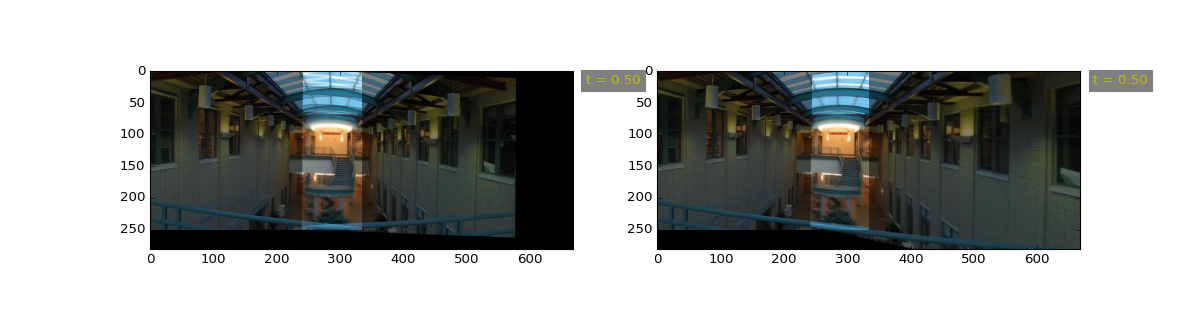

In [12]:
# estimating size of the reference frame (Ref) - the same image plane as "imL"
shapeRef = (imL.shape[0]+30, imL.shape[1]+imR.shape[1])

# copying Left image into reference frame (Ref) 
LtoRef = warp(imL, np.identity(3), output_shape = shapeRef)    # uses 3x3 identity matrix as transformation matrix

# WRITE YOUR CODE BELOW 

# warp the Right image (imR) into a reference frame of size "shapeRef" using two transformation estimated earlier 
# That is, obtain two new images:
# (A) RaffRef - using AffLtoR (affine map estimated from the corresponding points)
# (B) RprjRef - using PrjLtoR (homography estimated from the corresponding points)
RaffRef = warp(imR, AffLtoR, output_shape = shapeRef)
RprjRef = warp(imR, PrjLtoR, output_shape = shapeRef)

# compare registration of features in image LtoRef and the two images generated in (A) and (B) (RaffRef and RprjRef)
# HINT: you can use CrossDissolve to visualize pairs of images (LtoRef-RaffRef) and (LtoRef-RprjRef)  together
# WHICH TRANSFORMATION (Affine or Homographic) WORKS BETTER FOR ALIGNING (REGISTERING) imR to imL (LtoRef) ?
# SHOW YOUR RESULTS IN A FIGURE BELOW AND EXPLAIN IN A MARKDOWN CELL BELOW THE FIGURE 
fig = plt.figure(3,figsize = (15, 4))
ax12 = plt.subplot(121)
#plt.imshow(RaffRef)
css12 = CrossDissolver(ax12,LtoRef,RaffRef,'float')

ax34 = plt.subplot(122)
css34 = CrossDissolver(ax34,LtoRef,RprjRef,'float')

The homography works better than the affine transformation in aligning imR to imL. Since the properties of homographies are more flexible than affine transformations, the homography is better able to match the corresponding features. This is especially evident in the skylight, the railing, and how the homography better fits the frame because area ratios do not have to be preserved.

### Blending

In [13]:
    # This function compute a distance map from the boundary of an image.
    # It returns a numpy array of the same size as image with distances from each pixel to the border (float values) 
    def boundaryDT(image):
        # WRITE YOUR CODE THAT RETURNS A DISTANCE MAP (numpy array) THE SAME SHAPE (SIZE) AS "image"
        # WHERE EACH PIXEL (ARRAY ELEMENT) CONTAINS DISTANCE TO THE SLOSEST SIDE OF THE IMAGE
        # NOTE: the pixels right on the edge of the image should have distance 0.5 or 1.0
        # while each step away from the border should increase the distance by 1.0
        imRows = image.shape[0]
        imCols = image.shape[1]
        dtMap = np.empty(image.shape)
        for y in range(imRows):
            for x in range(imCols):
                dtMap[y,x] = min(x, y, imCols-1-x, imRows-1-y)+1.0
        
        return dtMap

In [14]:
# computing boundary distance map/transform (bdt) for two images
Ldt = boundaryDT(imL)
Rdt = boundaryDT(imR)

LdtRef = warp(Ldt, np.identity(3), output_shape = shapeRef)

#WRITE YOUR CODE BLEOW
# project/warp Rdt image (distance masp) into the reference frame to obtain  RdtRef
# 1 line below is wrong and should be replaced!!
RdtRef = warp(Rdt, PrjLtoR, output_shape = shapeRef)

# when debigging, you can visulaize your LdtRef and RdtRef below to check if you are getting expected results
#fig = plt.figure(4,figsize = (12, 4))
#plt.subplot(111)
#plt.imshow(RdtRef)

<IPython.core.display.Javascript object>


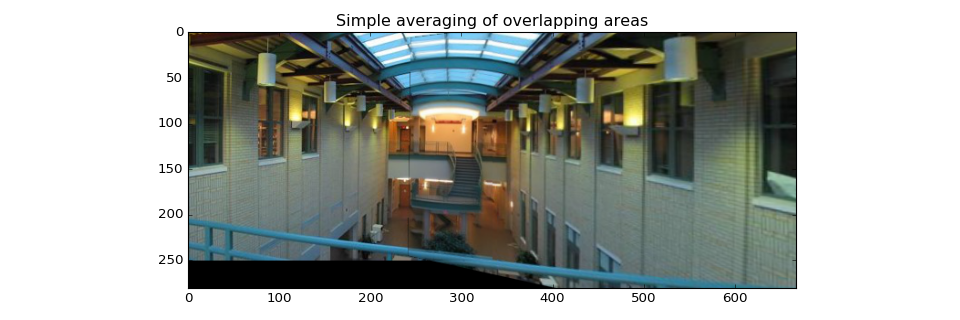

In [21]:
# WRITE YORU CODE BELOW:
# you should generate a mosaic by blending two images LtoRef and RprjRef
# USE TWO DIFFERENT BLENDING alphas (AS IN TOPIC 9) AND COMPARE YOUR RESULTS 
# (SHOW THE RESULTS AND DISCUSS THE DIFFERENCES IN A MARKDOWN CELL BELOW)

# METHOD 1: averaging intensities of two images in the overlap area
fig = plt.figure(4,figsize = (12, 4))
plt.subplot(111)
avgI = np.empty(LtoRef.shape)
for y in range(avgI.shape[0]):
    for x in range(avgI.shape[1]):
        if (np.sum(LtoRef[y,x]) == 0.0 or np.sum(RprjRef[y,x]) == 0.0):
            avgI[y,x] = LtoRef[y,x]+RprjRef[y,x]
        else:
            avgI[y,x] = LtoRef[y,x]*0.5+RprjRef[y,x]*0.5

plt.title("Simple averaging of overlapping areas")
plt.imshow(avgI)
# METHOD 2: DT-weighted averaging in the overlap area (using LdtRef and RdtRef generated above)

# numpy HINT 1: if you have an array "alpha" of shape (w,h) with scalers for each pixel 
#               of an RGB image A, which is an array of shape (w,h,3), then
#               you can use np.dstack((alpha,alpha,alpha)) to generate an array of shape (w,h,3)
#               assuming that you use the same slaler for R, G, and B values in each pixel
# numpy HINT 2: you can use operator A*B for pointwise multiplication of two matrices of the same shape
#               It returns array of the same shape where each element is the product of the corresponding elements in A and B
# numpy HINT 3: you can add the same scalar a to all elements in matrix A using a+A operation